In [2]:
##Load and Clean the Dataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Load dataset
df = pd.read_csv("2019_dataset_en.csv", low_memory=False)

In [5]:
# Drop ID columns and high-missing columns
drop_cols = ['C_YEAR', 'P_ID', 'C_ID', 'V_ID']
missing_thresh = len(df) * 0.3
drop_cols += [col for col in df.columns if df[col].isnull().sum() > missing_thresh]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

In [6]:
# Remove invalid entries for both targets
for target in ['P_ISEV', 'C_SEV']:
    df = df[df[target].apply(lambda x: str(x).isdigit())]

In [7]:
# Convert to int
df['P_ISEV'] = df['P_ISEV'].astype(int)
df['C_SEV'] = df['C_SEV'].astype(int)

In [8]:
# Print shape and preview
print("Cleaned dataset shape:", df.shape)
df.head()

Cleaned dataset shape: (251949, 20)


,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,1,1,11,2,2,32,1,1,5,4,18,1,2015,M,56,QQ,1,2,U,2681651
2,1,1,11,2,2,32,1,1,5,4,18,1,2010,F,30,11,2,2,1,2681651
4,1,1,16,2,2,32,1,2,5,3,18,1,2007,F,27,11,2,2,1,2681652
5,1,1,16,2,2,32,1,2,5,3,18,1,2007,F,5,33,1,2,2,2681652
6,1,1,16,2,2,32,1,2,5,3,18,1,2009,M,18,11,2,2,1,2681652


In [9]:
##Split and Encode for Both Targets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Drop targets temporarily to encode only features
df_features = df.drop(columns=['P_ISEV', 'C_SEV'])
df_encoded = pd.get_dummies(df_features, drop_first=True)

In [12]:
# Create datasets for each target
X_pisev = df_encoded.copy()
y_pisev = df['P_ISEV']

X_csev = df_encoded.copy()
y_csev = df['C_SEV']

In [13]:
# Split with stratification to handle imbalance
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_pisev, y_pisev, test_size=0.2, stratify=y_pisev, random_state=42)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_csev, y_csev, test_size=0.2, stratify=y_csev, random_state=42)

In [14]:
# Print confirmation
print("✅ Data split done.")
print("P_ISEV → Train:", X_train_p.shape, ", Test:", X_test_p.shape)
print("C_SEV  → Train:", X_train_c.shape, ", Test:", X_test_c.shape)

✅ Data split done.
P_ISEV → Train: (201559, 338) , Test: (50390, 338)
C_SEV  → Train: (201559, 338) , Test: (50390, 338)


In [14]:
##Ensemble for P_ISEV = RandomForest + XGBoost + AdaBoost

In [15]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Base learners
rf_p = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

xgb_p = XGBClassifier(
    objective='multi:softprob',
    num_class=len(set(y_train_p)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

ada_p = AdaBoostClassifier(n_estimators=100, random_state=42)

# Meta-learner
meta_lr = LogisticRegression(max_iter=1000, random_state=42)

In [17]:
# Stacking classifier
stack_p = StackingClassifier(
    estimators=[('rf', rf_p), ('xgb', xgb_p), ('ada', ada_p)],
    final_estimator=meta_lr,
    cv=5,          # 5-fold stacking
    n_jobs=-1,
    passthrough=False  # If True, raw features are passed to meta-model (optional)
)

In [18]:
# Fit and predict
stack_p.fit(X_train_p, y_train_p)
y_pred_p_stack = stack_p.predict(X_test_p)

In [19]:
# Evaluate
print("🔍 Classification Report – P_ISEV (Stacking):")
print(classification_report(y_test_p, y_pred_p_stack))
print(f"🎯 Accuracy: {accuracy_score(y_test_p, y_pred_p_stack):.4f}")

🔍 Classification Report – P_ISEV (Stacking):
              precision    recall  f1-score   support

           1       0.68      0.68      0.68     21877
           2       0.75      0.75      0.75     28160
           3       0.39      0.05      0.08       353

    accuracy                           0.72     50390
   macro avg       0.61      0.49      0.50     50390
weighted avg       0.72      0.72      0.72     50390

🎯 Accuracy: 0.7179


In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Re-initialize base models

rf_p = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

xgb_p = XGBClassifier(
    objective='multi:softprob',
    num_class=len(set(y_train_p)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

ada_p = AdaBoostClassifier(n_estimators=100, random_state=42)

# VotingClassifier with soft voting
voting_p_soft = VotingClassifier(
    estimators=[('rf', rf_p), ('xgb', xgb_p), ('ada', ada_p)],
    voting='soft'
)

In [33]:
# Fit on original (imbalanced) training data
voting_p_soft.fit(X_train_p, y_train_p)

# Predict
y_pred_p_soft = voting_p_soft.predict(X_test_p)

C:\Users\anujw\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [34]:
# Evaluate
print("🔍 Classification Report – P_ISEV (Soft Voting):")
print(classification_report(y_test_p, y_pred_p_soft))
print(f"🎯 Accuracy: {accuracy_score(y_test_p, y_pred_p_soft):.4f}")

🔍 Classification Report – P_ISEV (Soft Voting):
              precision    recall  f1-score   support

           1       0.69      0.66      0.68     21877
           2       0.74      0.77      0.75     28160
           3       0.00      0.00      0.00       353

    accuracy                           0.72     50390
   macro avg       0.48      0.48      0.48     50390
weighted avg       0.71      0.72      0.71     50390

🎯 Accuracy: 0.7176


✅ After SMOTE - Class distribution:
P_ISEV
1    0.333333
2    0.333333
3    0.333333
Name: proportion, dtype: float64


C:\Users\anujw\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:24:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 Classification Report – P_ISEV (SMOTE + Ensemble):
              precision    recall  f1-score   support

           1       0.64      0.72      0.68     21877
           2       0.75      0.68      0.71     28160
           3       0.15      0.09      0.11       353

    accuracy                           0.69     50390
   macro avg       0.51      0.50      0.50     50390
weighted avg       0.70      0.69      0.69     50390

🎯 Accuracy: 0.6920


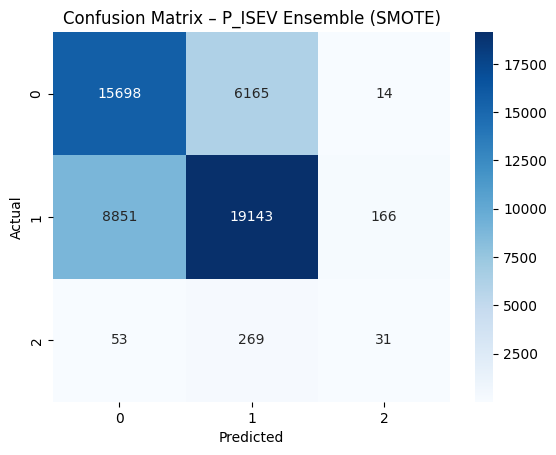

In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_p_bal, y_train_p_bal = smote.fit_resample(X_train_p, y_train_p)

print("✅ After SMOTE - Class distribution:")
print(y_train_p_bal.value_counts(normalize=True))

# Step 2: Define ensemble models
rf_p = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

xgb_p = XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y_train_p_bal)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

ada_p = AdaBoostClassifier(n_estimators=100, random_state=42)

voting_p = VotingClassifier(
    estimators=[('rf', rf_p), ('xgb', xgb_p), ('ada', ada_p)],
    voting='hard'  # You may test 'soft' if all models support predict_proba
)

# Step 3: Train ensemble on balanced data
voting_p.fit(X_train_p_bal, y_train_p_bal)

# Step 4: Predict on original (imbalanced) test set
y_pred_p = voting_p.predict(X_test_p)

# Step 5: Evaluate
print("🔍 Classification Report – P_ISEV (SMOTE + Ensemble):")
print(classification_report(y_test_p, y_pred_p))
print(f"🎯 Accuracy: {accuracy_score(y_test_p, y_pred_p):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_p, y_pred_p)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – P_ISEV Ensemble (SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [1]:
##Ensembling C_SEV

In [15]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Define base models
rf_c = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gb_c = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lr_c = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

In [17]:
# Meta-learner
meta_lr = LogisticRegression(max_iter=1000, random_state=42)

In [20]:
# StackingClassifier with fewer resources
stack_c = StackingClassifier(
    estimators=[('rf', rf_c), ('gb', gb_c), ('lr', lr_c)],
    final_estimator=meta_lr,
    cv=3,          # reduce folds to lower memory usage
    n_jobs=1       # run one model at a time
)

In [21]:
# Fit and predict
stack_c.fit(X_train_c, y_train_c)
y_pred_c_stack = stack_c.predict(X_test_c)

In [22]:
# Evaluate
print("🔍 Classification Report – C_SEV (Stacking - Low Resource):")
print(classification_report(y_test_c, y_pred_c_stack))
print(f"🎯 Accuracy: {accuracy_score(y_test_c, y_pred_c_stack):.4f}")

🔍 Classification Report – C_SEV (Stacking - Low Resource):
              precision    recall  f1-score   support

           1       0.81      0.40      0.54       826
           2       0.99      1.00      0.99     49564

    accuracy                           0.99     50390
   macro avg       0.90      0.70      0.77     50390
weighted avg       0.99      0.99      0.99     50390

🎯 Accuracy: 0.9886


In [24]:
# Soft voting classifier
from sklearn.ensemble import VotingClassifier
voting_c_soft = VotingClassifier(
    estimators=[('rf', rf_c), ('gb', gb_c), ('lr', lr_c)],
    voting='soft',
    weights=[1, 2, 1]  # optional: boost weight for best model
)

In [25]:
# Train
voting_c_soft.fit(X_train_c, y_train_c)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=42))],
                 voting='soft', weights=[1, 2, 1])

In [26]:
# Predict
y_pred_c_soft = voting_c_soft.predict(X_test_c)

In [27]:
# Evaluate
print("🔍 Classification Report – C_SEV (Soft Voting):")
print(classification_report(y_test_c, y_pred_c_soft))
print(f"🎯 Accuracy: {accuracy_score(y_test_c, y_pred_c_soft):.4f}")

🔍 Classification Report – C_SEV (Soft Voting):
              precision    recall  f1-score   support

           1       0.89      0.07      0.13       826
           2       0.98      1.00      0.99     49564

    accuracy                           0.98     50390
   macro avg       0.94      0.54      0.56     50390
weighted avg       0.98      0.98      0.98     50390

🎯 Accuracy: 0.9846
